<a href="https://colab.research.google.com/github/cartus0910/IOE_MGlab/blob/main/Anthro_x_ChatGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Anthro x ChatGPT


## Set up packages and tools

In [ ]:
import requests
from google.colab import files
import json
import pickle
import datetime
from bs4 import BeautifulSoup
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import pandas as pd
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import pprint
try:
  import nltk
  nltk.download('punkt')
  nltk.download('wordnet')
  nltk.download('stopwords')
except:
  !pip install nltk
  import nltk
  nltk.download('punkt')
  nltk.download('wordnet')
  nltk.download('stopwords')
try:
  import jieba
  import jieba.analyse
except:
  !pip install git+https://github.com/APCLab/jieba-tw.git
  import jieba
  import jieba.analyse
try:
  from hanziconv import HanziConv
except:
  !pip install hanziconv
  from hanziconv import HanziConv

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Jieba Tokenizer Settings

In [ ]:
# Set up Dictionary
### Dictionary for zh-tw
### https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
!curl -o ./dict.txt https://raw.githubusercontent.com/ldkrsi/jieba-zh_TW/master/jieba/dict.txt
file_path = './dict.txt'
jieba.set_dictionary(file_path)

# Import Self-defined Dictionary
"""
file_path = './termonology.txt'
word = '' # test word

print('載入自定義詞庫前: ',jieba.lcut(word, cut_all=False))
jieba.load_userdict(file_path)
print('載入自定義詞庫後: ',jieba.lcut(word, cut_all=False))
"""

# Set up Stopwords
# https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt
!curl -o ./stopword.txt https://raw.githubusercontent.com/goto456/stopwords/master/cn_stopwords.txt
file_name = './stopword.txt'
jieba.analyse.set_stop_words(file_name)

with open('./stopword.txt','r') as f:
  stop_words = f.readlines()
stop_words = [stop_word.rstrip() for stop_word in stop_words]
stop_words += [HanziConv.toTraditional(stop_word.rstrip()) for stop_word in stop_words]
stop_words += ['\n', ' ', '￼', '\u3000', '這', '會'] # add line break

def rv_stop_words(stop_words, seg_list):
  new_list = []

  for seg in seg_list:
    if (seg not in word_list) and (len(seg)>=2):
      new_list.append(seg)
  return new_list

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4057k  100 4057k    0     0  9117k      0 --:--:-- --:--:-- --:--:-- 9096k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4717  100  4717    0     0  32531      0 --:--:-- --:--:-- --:--:-- 32531


In [ ]:
# Colab display traditional Chinese when matplotlib processing
# download 台北思源黑體
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
#!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.7/dist-packages/matplotlib//mpl-data/fonts/ttf

font_path = 'taipei_sans_tc_beta.ttf'
fm.fontManager.addfont(font_path)

# Find font name in ttflist
#[f.name for f in fm.fontManager.ttflist]
plt.rcParams['font.family'] = 'Taipei Sans TC Beta'

--2023-05-22 03:08:02--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.204.102, 172.217.204.139, 172.217.204.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.204.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/01rt03416uns62c9juk37eh30fcf8ab4/1684724850000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=4c1aca0e-b593-41cb-8b72-ef8d1cedd9e0 [following]
--2023-05-22 03:08:03--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/01rt03416uns62c9juk37eh30fcf8ab4/1684724850000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_?uuid=4c1aca0e-b593-41cb-8b72-ef8d1cedd9e0
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connecting to d

## RAI2022 Panels


### 1. Crawling Abstracts

In [ ]:
url = "https://nomadit.co.uk/conference/rai2022/scope"
response = requests.get(url, params={"ConferenceID": 90, "OrganisationID": 5})
if response.status_code == 200:
  conference_json = response.json()
else:
  #return
  print("No Data Retrieved.")

panel_info = pd.DataFrame(columns=["Panel ID", "Panel Title", "Format", "Participants", "Description", "Paper"])
i = 0
for panel in conference_json["conference"]["panels"]:
  panelID = panel["PanelID"]
  panel_response = requests.get(url, params={"ConferenceID": 90, "OrganisationID": 5, "PanelID": panelID}).json()
  for p in panel_response["conference"]["panels"]:
    # Get all types of Participants
    participants = []
    if "Convenors" in p:
      participants += [(n["PersonID"], " ".join([n["FirstName"], n["LastName"]])) for n in p["Convenors"]]
    if "Chairs" in p:
      participants += [(n["PersonID"], " ".join([n["FirstName"], n["LastName"]])) for n in p["Chairs"]]
    if "Discussants" in p:
      participants += [(n["PersonID"], " ".join([n["FirstName"], n["LastName"]])) for n in p["Discussants"]]

    # for panels and roundtables with paper presented
    if p["Format"] in ["Panel", "Roundtable"]:
      for paper in p["Papers"]:
        paper_info = []
        authors = [(n["PersonID"], " ".join([n["FirstName"], n["LastName"]])) for n in paper["Authors"]]
        paper_info += (paper["PaperTitle"], authors, paper["PaperAbstract"])
        participants += authors
        i += 1
    else: # for film and plenary
      paper_info = None
    panel_info.loc[i,:] = [panelID,
                            p["Title"],
                            p["Format"],
                            participants,
                            p["Description"],
                            paper_info]
    i += 1

In [ ]:
panel_info.to_pickle("/content/drive/MyDrive/Anthro X AI/panels.pkl")

In [ ]:
panel_info = pd.read_pickle("/content/drive/MyDrive/Anthro X AI/panels.pkl")

#### A. Word Frequency

In [ ]:
panel_word_list = []
ps = nltk.stem.porter.PorterStemmer()
lm = nltk.stem.WordNetLemmatizer()
tokenizer = nltk.RegexpTokenizer(r'\w+')
for i, row in panel_info.iterrows():
  words = tokenizer.tokenize(row["Description"])
  words = [lm.lemmatize(ps.stem(word)) for word in words]
  panel_word_list += words
  if row["Paper"] != None:
    words = []
    if len(row["Paper"]) > 3:
      for paper in row["Paper"]:
        words = tokenizer.tokenize(paper[2])
        words = [lm.lemmatize(ps.stem(word)) for word in words]
        panel_word_list += words
    else:
      words = tokenizer.tokenize(row["Paper"][2])
      words = [lm.lemmatize(ps.stem(word)) for word in words]
      panel_word_list += words
panel_word_list = [word for word in panel_word_list if word not in stopwords.words('english')]

In [ ]:
panel_word_count = pd.Series(panel_word_list).value_counts()
panel_word_count

thi          358
ai           309
futur        278
technolog    241
human        218
            ... 
rehabilit      1
penal          1
marri          1
variat         1
addresse       1
Length: 3899, dtype: int64

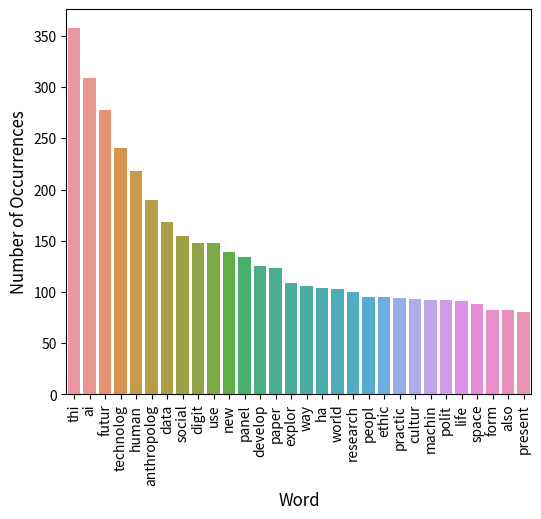

In [ ]:
wcounts_max30 = panel_word_count.nlargest(30)

fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(x=wcounts_max30.index, y=wcounts_max30.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

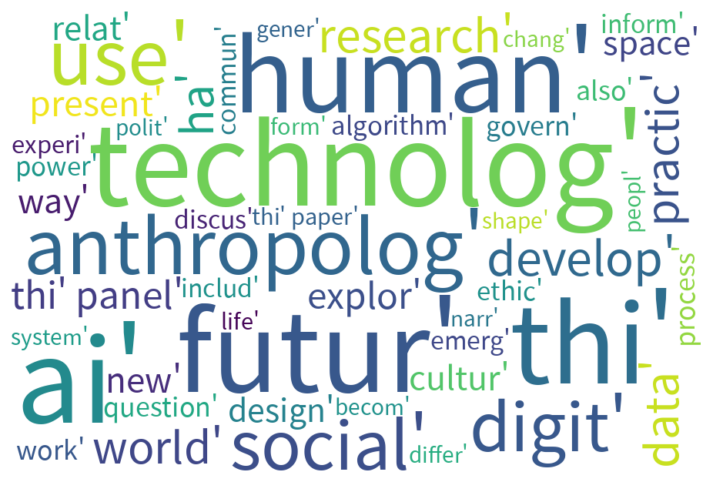

In [ ]:
wordcloud = WordCloud(font_path=font_path, max_font_size=150, max_words=50, background_color="white", width=900, height=600).generate(str(panel_word_list))
fig, ax = plt.subplots(figsize=(9, 6))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.show()

#### B. Wordcloud

## Cofacts Rumor Data

### 1. Extract Rumours Report from Cofacts API

In [ ]:
url = "https://api.cofacts.tw/graphql"
body = """
query GetArticlesList($filter: ListArticleFilter, $orderBy: [ListArticleOrderBy], $after: String) {
  ListArticles(filter: $filter, orderBy: $orderBy, after: $after, first: 200) {
    edges {
      node {
        id
        ...ArticleCard
        __typename
      }
      ...LoadMoreEdge
      __typename
    }
    __typename
  }
}

fragment ArticleCard on Article {
  id
  text
  replyRequestCount
  articleCategories {
  category{
    title
  }}
  replyCount
  replyRequestCount
  articleReplies {
    reply{
      text
      createdAt
      type
    }
  }
  aiReplies{
    createdAt
    text
  }
  stats {
    date
    webVisit
    lineVisit
    liffVisit
    liff {
      source
      visit
      __typename
    }
    __typename
  }
  createdAt
  ...ThumbnailArticleData
  __typename
}

fragment ThumbnailArticleData on Article {
  articleType
  text
  thumbnailUrl: attachmentUrl(variant: THUMBNAIL)
  __typename
}

fragment LoadMoreEdge on Edge {
  cursor
  __typename
}

"""

response = requests.post(url=url, json={"query": body})
print("response status code: ", response.status_code)
if response.status_code == 200:
  sample = json.loads(response.content.decode("utf8"))
  print("Data Structure: ")
  pprint.pprint(sample["data"]["ListArticles"]["edges"][0])

response status code:  200
Data Structure: 
{'__typename': 'ArticleConnectionEdge',
 'cursor': 'WyJ6enl0NzEwcW81NnUiXQ==',
 'node': {'__typename': 'Article',
          'aiReplies': [],
          'articleCategories': [{'category': {'title': '電力、能源'}}],
          'articleReplies': [{'reply': {'createdAt': '2018-05-17T12:41:32.544Z',
                                        'text': '經濟部發布澄清稿強調，推動再生能源是考量整體能源政策，非僅侷限於成本效益進行評估；另外，離岸風電是綠能發電，有益於提升環境生活品質。\n'
                                                '林全能說，離岸風力發電初期發電成本雖高，但未來隨著相關設備均建置完全，發電成本也會跟著降低。',
                                        'type': 'RUMOR'}}],
          'articleType': 'TEXT',
          'createdAt': '2018-05-17T06:49:40.220Z',
          'id': 'zzyt710qo56u',
          'replyCount': 1,
          'replyRequestCount': 1,
          'stats': [],
          'text': '依照太陽產生熱能的“核聚變”反應原理研發的發電裝置“人造太陽”，不但不會有核廢料產生，而且需要多少電能就能產生多少電能。\n'
                  '所以要想去核電而不斷電，就必須跟上世界能源的新趨勢用“超導發電“。\n'
                  '擁有高科技的先進國家現今都不敢輕言廢核，而且紛紛要貫徹於近幾年終

### 2. Restructuring Data

In [ ]:
# Data Cleaning
articles = pd.DataFrame(map(lambda node: {
                               "ID": node['node']['id'],
                               "Datetime": datetime.datetime.strptime(node['node']['createdAt'], "%Y-%m-%dT%H:%M:%S.%fZ"),
                               "Text": node['node']['text'],
                               "Requests Count": node['node']['replyRequestCount'],
                               "Category": [c['category']['title'] if len(c)!=0 else None for c in node['node']['articleCategories']],
                               "Replies": [(r['reply']['createdAt'], r['reply']['text'], r['reply']['type']) if len(r)!=0 else None for r in node['node']['articleReplies']],
                               "AI Replies": [(ai['createdAt'], ai['text']) if len(ai)!=0 else None for ai in node['node']['aiReplies']],
                               "Statistics": dict((datetime.datetime.fromisoformat(s['date']), sum(filter(None, [s['webVisit'], s['lineVisit'], s['liffVisit']]))) if len(s)!=0 else None for s in node['node']['stats'])},
                 sample["data"]["ListArticles"]["edges"]))
# remove empty texts
articles['Text'].replace('', np.nan, inplace=True)
articles.dropna(subset=['Text'], inplace=True)

print(len(articles))
articles.head

171


<bound method NDFrame.head of                ID                Datetime  \
0    zzyt710qo56u 2018-05-17 06:49:40.220   
1    zzysjdj4mkpe 2022-09-07 14:39:25.167   
2    zzxtkikjhlvi 2022-04-22 03:54:48.583   
3    zzxoot0zb20r 2022-08-26 10:32:35.776   
4    zzw8x07tshew 2019-11-02 15:20:44.333   
..            ...                     ...   
195  zqph5egeyqph 2022-03-04 17:45:00.353   
196  zqofkdayt8do 2020-03-20 15:54:56.046   
197  zqlv3r1ktt4d 2022-12-25 14:01:54.889   
198  zql9ubrm2g2a 2022-09-16 06:26:41.315   
199  zql5oqdlwxgp 2018-06-27 02:51:19.571   

                                                  Text  Requests Count  \
0    依照太陽產生熱能的“核聚變”反應原理研發的發電裝置“人造太陽”，不但不會有核廢料產生，而且需...               1   
1                                               手機處理訂單               1   
2                                            半個台灣非法豆奶攤               2   
3     【衛生福利部】提領防疫補助補貼,點 www.riigov.tv   提領（複製網址到瀏覽器打開）               1   
4    Bingo! \n我剛剛跟一個26歲年輕人溝通很久…\n又終於突破這位年輕人的心房了! 爽!...     

171


<bound method NDFrame.head of                ID                Datetime  \
0    zzyt710qo56u 2018-05-17 06:49:40.220   
1    zzysjdj4mkpe 2022-09-07 14:39:25.167   
2    zzxtkikjhlvi 2022-04-22 03:54:48.583   
3    zzxoot0zb20r 2022-08-26 10:32:35.776   
4    zzw8x07tshew 2019-11-02 15:20:44.333   
..            ...                     ...   
195  zqph5egeyqph 2022-03-04 17:45:00.353   
196  zqofkdayt8do 2020-03-20 15:54:56.046   
197  zqlv3r1ktt4d 2022-12-25 14:01:54.889   
198  zql9ubrm2g2a 2022-09-16 06:26:41.315   
199  zql5oqdlwxgp 2018-06-27 02:51:19.571   

                                                  Text  Requests Count  \
0    依照太陽產生熱能的“核聚變”反應原理研發的發電裝置“人造太陽”，不但不會有核廢料產生，而且需...               1   
1                                               手機處理訂單               1   
2                                            半個台灣非法豆奶攤               2   
3     【衛生福利部】提領防疫補助補貼,點 www.riigov.tv   提領（複製網址到瀏覽器打開）               1   
4    Bingo! \n我剛剛跟一個26歲年輕人溝通很久…\n又終於突破這位年輕人的心房了! 爽!...     

### 3. Word Statistics

In [ ]:
Message_stats = pd.DataFrame(columns=["Category", "YM-Date", "Message_ID", 'Text', "Requests_Count", "Reported"])
Reply_stats = pd.DataFrame(columns=["Category", "YM-Date", "Message_ID", "Reply", "Reported"])

In [ ]:
for i, row in articles.iterrows():
  r_type = [r[2] for r in row["Replies"]]
  Message_stats.loc[i,:] = [row["Category"],
                            row["Datetime"].replace(day=1),
                            row["ID"], row["Text"],
                            row["Requests Count"],
                            # set the most frequent reported type as it is
                            (max(r_type, key=r_type.count) if len(r_type)!=0 else None)]
  for r in row["Replies"]:
    Reply_stats.loc[i,:] = [row["Category"],
                            datetime.datetime.strptime(r[0], "%Y-%m-%dT%H:%M:%S.%fZ").replace(day=1),
                            row["ID"], r[1], r[2]]

#### A. Word Frequency

In [ ]:
Message_stats['tokenized_text'] = str()
Reply_stats['tokenized_text'] = str()
for i, row in Message_stats.iterrows():
  seg_result = json.loads(requests.post("https://textseg.sgis.tw/", {"query":row['Text'], "mode":2}).text)[0]["words"]
  seg_list = rv_stop_words(stop_words, seg_result)
  Message_stats.loc[i, 'tokenized_text'] = seg_list
for i, row in Reply_stats.iterrows():
  seg_result = json.loads(requests.post("https://textseg.sgis.tw/", {"query":row['Reply'], "mode":2}).text)[0]["words"]
  seg_list = rv_stop_words(stop_words, seg_result)
  Reply_stats.loc[i, 'tokenized_text'] = seg_list

In [ ]:
Message_stats.to_pickle("/content/drive/MyDrive/Anthro X AI/message.pkl")
Reply_stats.to_pickle("/content/drive/MyDrive/Anthro X AI/reply.pkl")

In [ ]:
Message_stats = pd.read_pickle("/content/drive/MyDrive/Anthro X AI/message.pkl")
Reply_stats = pd.read_pickle("/content/drive/MyDrive/Anthro X AI/reply.pkl")

In [ ]:
message_word_list = Message_stats['tokenized_text'].sum()
message_wcounts = pd.Series(message_word_list).value_counts()
message_wcounts

台灣             160
疫苗              91
https           79
政府              61
沒有              60
              ... 
麥卡倫              1
格登               1
百富               1
約翰               1
AKCNqR60dq8      1
Length: 5442, dtype: int64

In [ ]:
reply_word_list = Reply_stats['tokenized_text'].sum()
reply_wcounts = pd.Series(reply_word_list).value_counts()
reply_wcounts

民眾      24
沒有      23
相關      22
詐騙      21
台灣      20
        ..
聯亞生技     1
期中報告     1
三期       1
沒出       1
說詞       1
Length: 2177, dtype: int64

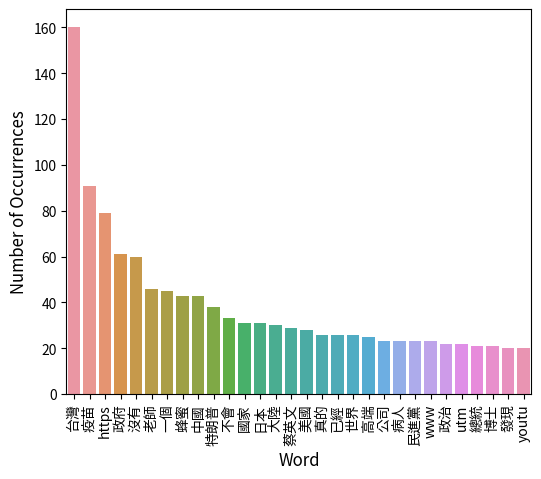

In [ ]:
wcounts_max30 = message_wcounts.nlargest(30)

fig, ax = plt.subplots(figsize=(6,5))
sns.barplot(x=wcounts_max30.index, y=wcounts_max30.values, ax=ax)
ax.set_ylabel('Number of Occurrences', fontsize=12)
ax.set_xlabel('Word', fontsize=12)
ax.xaxis.set_tick_params(rotation=90)

#### B. Word Cloud

B1: Wordcloud for Messages

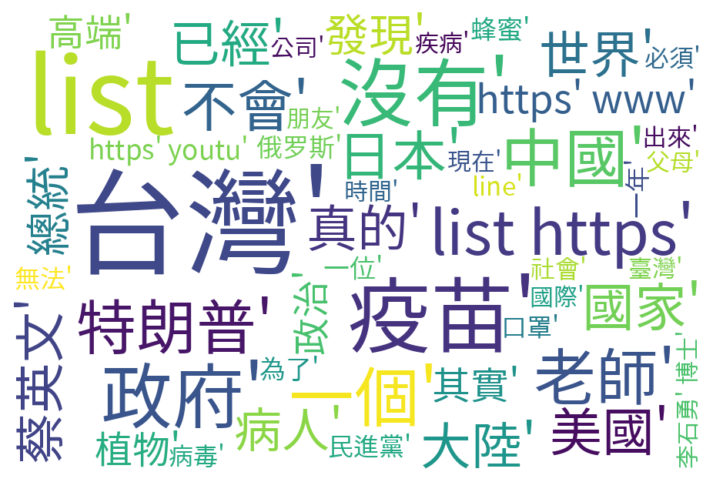

In [ ]:
msg_text = Message_stats['tokenized_text'].values
wordcloud = WordCloud(font_path=font_path, max_font_size=150, max_words=50, background_color="white", width=900, height=600).generate(str(msg_text))
fig, ax = plt.subplots(figsize=(9, 6))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.show()